<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Создание-новых-признаков:" data-toc-modified-id="Создание-новых-признаков:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание новых признаков:</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Ridge:" data-toc-modified-id="Ridge:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ridge:</a></span></li><li><span><a href="#RandomForestRegressor:" data-toc-modified-id="RandomForestRegressor:-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RandomForestRegressor:</a></span></li><li><span><a href="#LigthGBM-Regressor:" data-toc-modified-id="LigthGBM-Regressor:-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LigthGBM Regressor:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала установим все необходимые ресурсы и импортируем библиотеки:

In [ ]:
!pip install -q shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import calendar

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import shap

In [ ]:
df=pd.read_csv('/datasets/taxi.csv')

Для удобства создадим функцию для отображения первых и послених 10 строк датасета, общей информации и числовых характеристик:

In [ ]:
def read(df):
    display(df.head(10))
    print()
    display(df.tail(10))
    print()
    print(df.info())
    print()
    print(df.describe())
    print()

In [ ]:
read(df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


,datetime,num_orders
26486,2018-08-31 22:20:00,48
26487,2018-08-31 22:30:00,41
26488,2018-08-31 22:40:00,34
26489,2018-08-31 22:50:00,34
26490,2018-08-31 23:00:00,30
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000



В датасете 2 признака - временной промежуток, равный 10 минутам и количество заказов, произведенные за эти 10 минут. Указан неверный тип данных у признака datetime.

Проверим, есть ли пропуски в значениях:

In [ ]:
 df.isna().mean()

datetime      0.0
num_orders    0.0
dtype: float64

Пропусков нет, можно переходить к преобразованиям - для начала преобразуем тип данных и установим датаиндекс:

In [ ]:
df=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

Отсортируем данные по индексу по возрастанию и проверим, расположены ли они в хронологическом порядке:

In [ ]:
df=df.sort_index(ascending=True)
df.index.is_monotonic

True

Посмотрим, как изменилось распределение:

In [ ]:
read(df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000



Данные предобработаны и изучены, установлен датаиндекс, датасет проверен на наличие пропусков и учтен ли хронологический порядок временных рядов, заменен тип данных object на datetime.

Переходим к статистическому анализу данных и созданию новых признаков для дальнейшего машинного обучения моделей./

## Анализ

Вычислим тренд и сезонность.

* проведем ресемплирование по 1 часу, и на основе этого датасета построим график, на который добавим также "скользящее среднее" за сутки и за неделю:

In [ ]:
df_1H=df.resample('1H').sum()

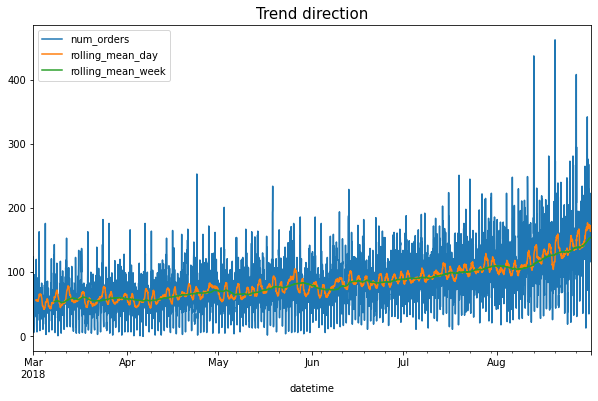

In [ ]:
df_1H['rolling_mean_day']=df_1H['num_orders'].shift().rolling(24).mean()
df_1H['rolling_mean_week'] = df_1H['num_orders'].shift().rolling(168).mean()
df_1H.plot(figsize=(10,6));
plt.title('Trend direction', fontsize=15);

На графике представлен ярко выраженный тренд - ежемесячное увеличение числа заказов с конца весны по начало осени.

* теперь расмотрим сезонность в разных масштабах - суточную и недельную:

In [ ]:
decomposed_1H = seasonal_decompose(df.resample('1H').sum())
decomposed_1D = seasonal_decompose(df.resample('1D').sum())

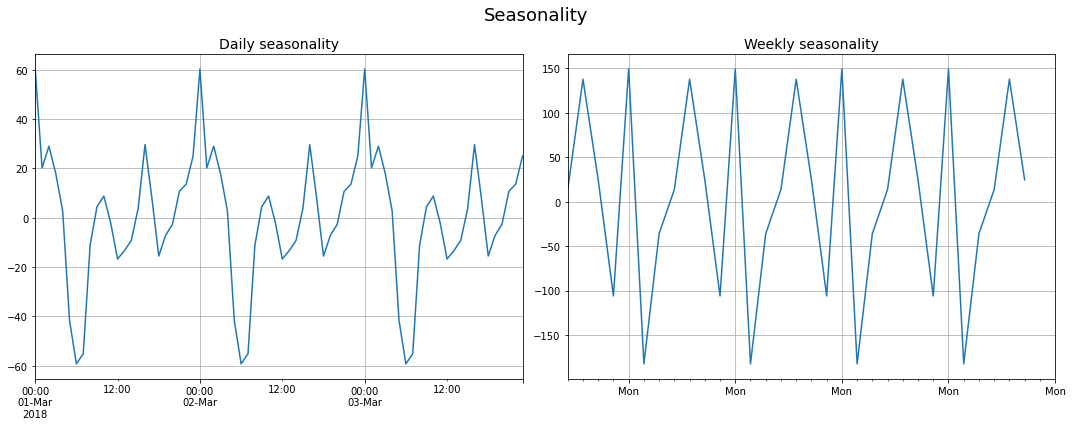

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Seasonality',fontsize=18)

decomposed_1H.seasonal['2018-03-01':'2018-03-03'].plot(ax=ax1)
ax1.set_title('Daily seasonality',fontsize=14)
ax1.set_xlabel('')
ax1.grid(True)


decomposed_1D.seasonal['2018-03-01':'2018-03-31'].plot(ax=ax2)
ax2.set_title('Weekly seasonality',fontsize=14)
ax2.set_xlabel('')
ax2.grid(True)

weekly_labels = pd.date_range(start='2018-03-01', end='2018-03-31', freq='7D') + pd.DateOffset(days=4)
weekday_names = [calendar.day_abbr[date.weekday()] for date in weekly_labels]
ax2.set_xticks(weekly_labels)
ax2.set_xticklabels(weekday_names, rotation=0)

plt.tight_layout()
plt.show()

 Обнаруженаы ярковыраженные закономерности:
 * пик заказов такси в течение дня приходится на вечернее время, ночью наблюдается сильный спад, и некоторые колебания в частоте заказов с утра до ужина;
 * также ярко выражена недельная сезонность - маленькое количество закзаов в начале недели, прирост к выходным, что вполне оправдано со стороны житейского опыта.

Ониоворят нам о важности таких признаков, как "час" и "день". Переходим к созданию новых переменных.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Ты немного торопишься. Важно исследовать наш полученный временной ряд, построить график ряда + исследовать сезонность (т.е. использовать специфичные инструменты, предназначенные именно для временных рядов).

И когда ты хорошо разберешься с нашими данными, поймешь их специфику, нужно создавать признаки, опираясь на результаты анализа.
</div>

## Создание новых признаков:

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Как и просил, к созданию признаков перехожу после разбора тренда и сезонности.
</div>

Сохраням наш датасет, как ресемплированный по часам:

In [ ]:
df=df_1H.copy()

Создадим функцию, возвращающую календарные признаки и отстающие значения:

In [ ]:
def make_features(data, max_lag):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1,max_lag+1):
        data['lag_{}'.format(lag)]=data['num_orders'].shift(lag)

Я решил добавить 24 отстающих значения, каждое на 1 час в сутках:

In [ ]:
make_features(df,24)

Удалим строки с пропусками, полученными в процессе создания новых признаков.

In [ ]:
df=df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_orders         4248 non-null   int64  
 1   rolling_mean_day   4248 non-null   float64
 2   rolling_mean_week  4248 non-null   float64
 3   hour               4248 non-null   int64  
 4   dayofweek          4248 non-null   int64  
 5   lag_1              4248 non-null   float64
 6   lag_2              4248 non-null   float64
 7   lag_3              4248 non-null   float64
 8   lag_4              4248 non-null   float64
 9   lag_5              4248 non-null   float64
 10  lag_6              4248 non-null   float64
 11  lag_7              4248 non-null   float64
 12  lag_8              4248 non-null   float64
 13  lag_9              4248 non-null   float64
 14  lag_10             4248 non-null   float64
 15  lag_11             4248 non-

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Из календарных признаков оставил - час и день недели, также добавил скользящее среднее за неделю.
</div>

## Обучение

Для  дальнейшего обучения моделей выделим тренировочную и тестовую выборки. Нам важен порядок в данных - "отделим" от нашего датафрейма последние 10% для теста, и разделим выборки на фичи и таргеты:

In [ ]:
train_size = int(0.9 * len(df))
train_data, test_data = df[:train_size], df[train_size:]

X_train=train_data.drop('num_orders', axis=1)
y_train=train_data['num_orders']

X_test=test_data.drop('num_orders', axis=1)
y_test=test_data['num_orders']

Для дальнейшего исследования я выбрал три модели - Ridge, Random Forest Regressor и LightGBM Regressor.

### Ridge:

Для оптимизации гиперпараматров методом GridSearchCV воспользуемся инструментом TimeSeriesSplit:

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'alpha': [0.005,0.01, 0.1, 1.0],
}

ridge_model = Ridge()

grid_search = GridSearchCV(ridge_model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение RMSE:", np.sqrt(-grid_search.best_score_))

Лучшие параметры: {'alpha': 1.0}
Лучшее значение RMSE: 27.512679693149888


### RandomForestRegressor:

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

rf_model = RandomForestRegressor()

grid_search = GridSearchCV(rf_model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение RMSE:", np.sqrt(-grid_search.best_score_))

Лучшие параметры: {'max_depth': None, 'n_estimators': 200}
Лучшее значение RMSE: 25.691466709849337


### LigthGBM Regressor:

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'learning_rate': [0.1, 0.2],
}

lgbm_model = LGBMRegressor()

grid_search = GridSearchCV(lgbm_model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение RMSE:", np.sqrt(-grid_search.best_score_))

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
Лучшее значение RMSE: 25.533116578459577


Лучший показатель RMSE был обнаружен у модели LigthGBM Regressor. Проверим ее на тестовых данных.

## Тестирование

In [ ]:
y_pred_l=grid_search.best_estimator_.predict(X_test)
print("Значение RMSE на тестовой выборке:", np.sqrt(mean_squared_error(y_test,y_pred_l)))

Значение RMSE на тестовой выборке: 41.801385994837005


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента</b></font>
   
Провел тестирование через best_estimator_.
</div>

Модель показала достаточное значение RMSE на тестовой выборке, проверим ее на адекватность используя Dummy модель:

In [ ]:
model= DummyRegressor()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
rmse_dm=np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE DummyRegressor:',rmse_dm)

RMSE DummyRegressor: 84.45113423436631


Очевидно, что модель адекватна и ее можно запускать в использование.  

Рассмотрим также более подробно как модель предсказывает значения и какие фичи являются важными для построения предсказаний.

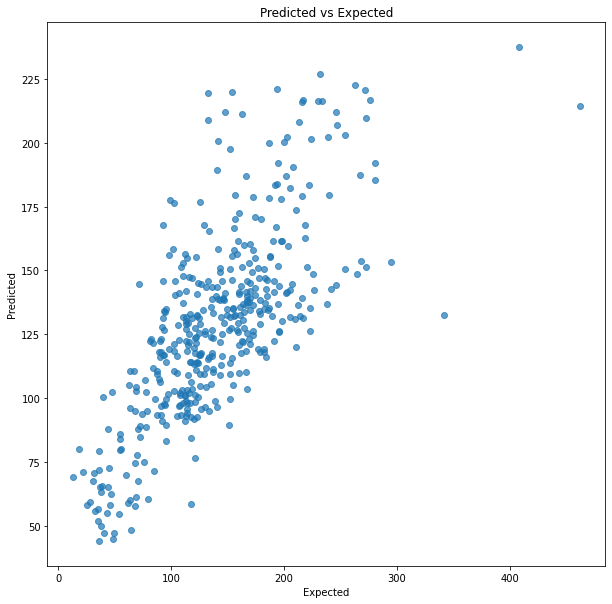

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_lgb,alpha=0.7)
plt.xlabel("Expected")
plt.ylabel("Predicted")
plt.title("Predicted vs Expected")
plt.show()

Модель сравнительно неплохо предсказывает значения до 200, когда значения таргета больше модель уже сложнее справляется с этой задачей.

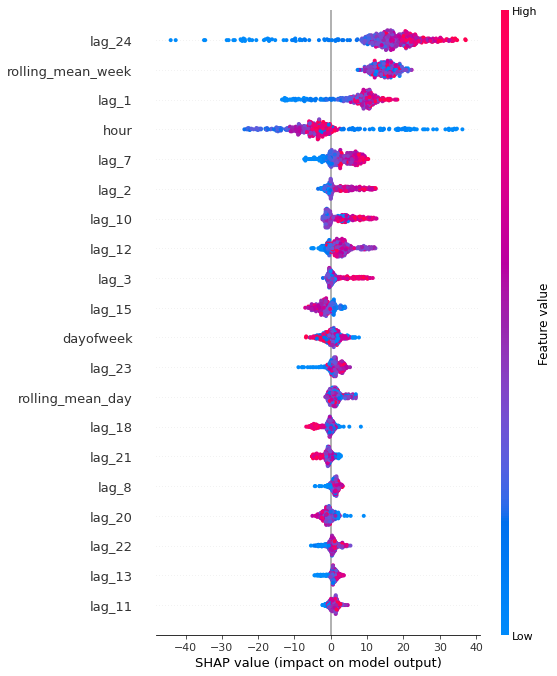

In [ ]:
explainer = shap.TreeExplainer(model_lgb)

shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.summary_plot(shap_values, X_test)

Наиболее важными оказались синтезированные признаки lag_1, lag_2 и rolling_mean_week.

**Вывод**: Нам был предоставлен датасет с количеством заказов в 10 минут с 1 марта 2018 по 1 сентября 2018 года.  Задача - научиться предсказывать количество заказов в час.

Для решения этого вопроса была произведена предобработка данных, ресемплирование данных по часу, создание новых признако - отстающих значений (24) и скользящего среднего и стандартного отклонения за 24 часа.

Также произведен статистический анализ, выявлен тренд плавного увеличения числа заказов с конца весны по начало осени, а также небольшое увеличение среднего числа заказов к концу каждого месяца.  

Для обучения были выбраны три модели: Ridge, Random Forest Regressor и LightGBM Regressor. Была определена лучшая - LightGBM Regressor (RMSE на тестоых данных = 41.5). Модель была проверена на адекватность, а также были выявлены самые значимые фичи - синтезированные признаки lag_1, lag_2 и rolling_mean_week.

На мой взгляд значение RMSE все равно давольно высокое, еди